In [56]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow import Tensor, image, random, cast, float32, function, data, newaxis, argmax
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ReLU, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import preprocessing as kp
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [33]:

def get_fcn(*, input_shape: tuple, classes: int) -> Model:
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=2,
                     padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", strides=2))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", strides=2))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(filters=classes, kernel_size=(1, 1), padding="same"))
    model.add(Conv2DTranspose(filters=classes, kernel_size=(16, 16), strides=2 ** 3, padding="same"))
    return model

In [34]:
fcn = get_fcn(input_shape=(128, 128, 3), classes=3)
fcn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)      

In [35]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, download=False)

In [36]:
def normalize(input_image, input_mask):
    """
    图像标准化到 [0,1]。最后，如上文提到的，像素点在图像分割掩码中被标记为 {1, 2, 3} 中的一个。为了方便起见，我们将分割掩码都减 1，得到了以下的标签：{0, 1, 2}

    :param input_image:
    :param input_mask:
    :return:
    """
    input_image = cast(input_image, float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@function
def load_image_train(datapoint: data.Dataset):
    """
    进行了一个简单的图像翻转扩充
    :param datapoint:
    :return:
    """
    input_image = image.resize(datapoint['image'], (128, 128))
    input_mask = image.resize(datapoint['segmentation_mask'], (128, 128))

    if random.uniform(()) > 0.5:
        input_image = image.flip_left_right(input_image)
        input_mask = image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint: data.Dataset):
    input_image = image.resize(datapoint['image'], (128, 128))
    input_mask = image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [37]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000

3680


In [38]:
train = dataset['train'].map(load_image_train, num_parallel_calls=data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [39]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(64)
train_dataset = train_dataset.prefetch(buffer_size=data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [40]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(kp.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

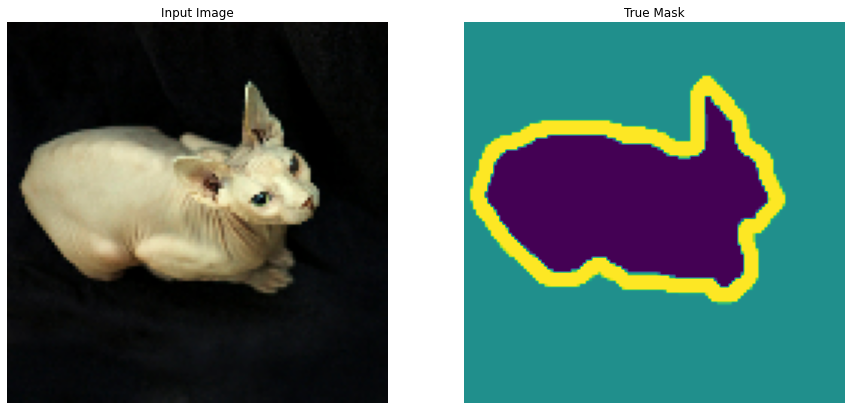

In [41]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [45]:
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
fcn.compile(optimizer=sgd, loss=SparseCategoricalCrossentropy(from_logits=True), metrics=["acc"])

In [46]:
# print(train_y.shape, fcn(train_x[:, :, :]).shape)
history = fcn.fit(train_dataset, epochs=50, validation_data=test_dataset, verbose=1)

Epoch 1/50
58/58 [==============================] - 8s 131ms/step - loss: 0.9924 - acc: 0.5774 - val_loss: 0.9845 - val_acc: 0.5698
Epoch 2/50
58/58 [==============================] - 7s 129ms/step - loss: 0.9674 - acc: 0.5799 - val_loss: 0.9648 - val_acc: 0.5714
Epoch 3/50
58/58 [==============================] - 8s 136ms/step - loss: 0.9495 - acc: 0.5807 - val_loss: 0.9513 - val_acc: 0.5719
Epoch 4/50
58/58 [==============================] - 7s 130ms/step - loss: 0.9368 - acc: 0.5809 - val_loss: 0.9417 - val_acc: 0.5721
Epoch 5/50
58/58 [==============================] - 7s 129ms/step - loss: 0.9275 - acc: 0.5810 - val_loss: 0.9344 - val_acc: 0.5721
Epoch 6/50
58/58 [==============================] - 7s 127ms/step - loss: 0.9202 - acc: 0.5810 - val_loss: 0.9285 - val_acc: 0.5721
Epoch 7/50
58/58 [==============================] - 8s 137ms/step - loss: 0.9140 - acc: 0.5810 - val_loss: 0.9231 - val_acc: 0.5721
Epoch 8/50
58/58 [==============================] - 7s 129ms/step - loss: 0.

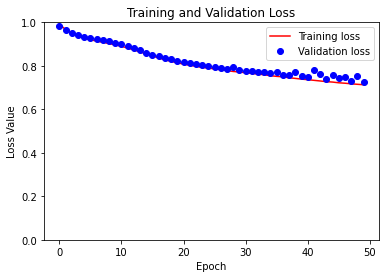

In [61]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(50)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

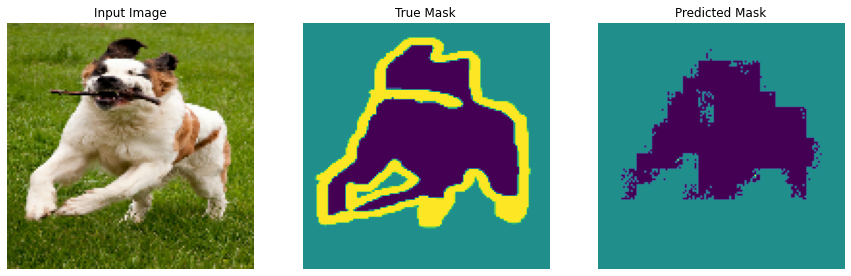

In [60]:
for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image[2], mask[2]
    test_image = sample_image[newaxis, ...]
    p_mask = fcn.predict(test_image)
    label_p = argmax(p_mask, axis=-1)
    label_p = label_p[..., newaxis]
    display([sample_image, sample_mask, label_p[0]])

In [14]:
from tensorflow import constant, data, zeros
import numpy as np

z = np.array([0, 6, 2, 1, 0, 0, 0], dtype="int32")
print(z, z.shape)
a = constant([[[[1, 2, 3], [3, 2, 1]], [[1, 1, 0], [3, 1, 2]]]])
print(b:=(a[:,:,:,0] + a[:,:,:,1]+a[:,:,:,2]))
print(z[b.numpy()])
print(b)


[0 6 2 1 0 0 0] (7,)
tf.Tensor(
[[[6 6]
  [2 6]]], shape=(1, 2, 2), dtype=int32)
[[[0 0]
  [2 0]]]
tf.Tensor(
[[[6 6]
  [2 6]]], shape=(1, 2, 2), dtype=int32)
